In [5]:
import numpy as np
import pandas as pd
import csv
import matplotlib
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import scipy.stats as sst
import networkx as nx

%matplotlib inline
pd.options.display.max_rows = 500
pd.options.display.max_columns = 400
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Key function to calculate policy relatedness

In [15]:

# This code calculates policy relatedness based on two functional forms:
# One is based on Hidalgo etl al 2007 (denoted hh_relatedness)
# The other is based on Zaccharia et al 2015 (denoted weighted_relatedness), as it weights the Hidalgo 2007 hh_relatedness by the
# number of policies countries have introduced

def calculate_hh_and_weighted_policy_relatedness(M):
    """
    Calculates policy relatedness measures from the M matrix based on 
    two functional forms introduced by Hidalgo et al 2007 and Zaccharia et al 2015 

    Returns
    -------
    Policy relatedness matrices based on these two different functional forms
    """      
    ii = len(M[:,0]) # number of policies
    jj = len(M[0,:]) # number of countries
    
    # Create relatedness matrix for policies
    hh_relatedness_mat = np.zeros((ii,ii))
    weighted_relatedness_mat = np.zeros((ii,ii))
    
    R_i = M.sum(axis = 0)
    
    # For each policy vector in the M matrix, 
    # calculate the relatedness to all other policy vectors
    for this_policy in range(ii):
        this_policy_vec = M[this_policy,:]
        for other_policy in range(ii):
            other_policy_vec = M[other_policy,:]
            overlap = this_policy_vec * other_policy_vec
            pwcp_ij = overlap.sum()/float(this_policy_vec.sum())
            pwcp_ji = overlap.sum()/float(other_policy_vec.sum())            
            
            hh_relatedness_mat[this_policy,other_policy] = np.nan_to_num(min(pwcp_ij,pwcp_ji))
            
    # Now weight the overlap by country policy diversity (1/R_i) - 
    # such that countries that have introduced more policies are assigned lower weight
            overlap_weighted = np.true_divide(overlap,R_i)
            w_pwcp_ij = overlap_weighted.sum()/float(this_policy_vec.sum())
            w_pwcp_ji = overlap_weighted.sum()/float(other_policy_vec.sum())
            
            weighted_relatedness_mat[this_policy,other_policy] = np.nan_to_num(min(w_pwcp_ij,w_pwcp_ji))
                                    
    return hh_relatedness_mat,weighted_relatedness_mat

### Read in data and calculate policy relatedness matrices

In [16]:
# Read in N matrix 
N = np.loadtxt('github_intermediate/N_matrix.csv', delimiter = ',')

# Read in M matrix 

# M matrix based on N_ci
#M = np.loadtxt('github_intermediate/M_Nci_matrix.csv', delimiter = ',')
#M_df = pd.read_csv('github_intermediate/M_Nci_df.csv',index_col=[0])

# M matrix based on RPP
M = np.loadtxt('github_intermediate/M_RPP_matrix.csv', delimiter = ',')
M_df = pd.read_csv('github_intermediate/M_RPP_df.csv',index_col=[0])

# Calculate policy relatedness matrices based on two alternative functional forms
hh_relatedness_mat_policy, weighted_relatedness_mat_policy = calculate_hh_and_weighted_policy_relatedness(M.transpose())


## Construct Climate Policy Space Network

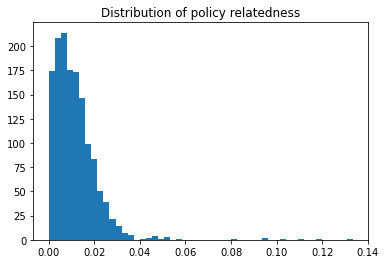

threshold: 0.016849431725201383


In [17]:

# Invesigate the distribution of relatedness values (here we look at the weighted relatedness measure)
relatedness_distribution = []
for i in range(len(weighted_relatedness_mat_policy[0,:])):
    for j in range(len(weighted_relatedness_mat_policy[0,:])):
        if i > j:            
            relatedness_distribution.append(weighted_relatedness_mat_policy[i,j])
            
plt.hist(relatedness_distribution,bins = 50)
plt.title('Distribution of policy relatedness')
plt.show()   

# Select threshold value above which to include edges in CPS network
mean = np.mean(relatedness_distribution)
sd = np.std(relatedness_distribution)
thresh = mean + 0.5*sd
print('threshold:',thresh)

### Key function for calculating network based on maximum spanning tree and adding additional edges greater than the threshold value determined above


In [18]:
def create_mst_plus_edges(complete_graph,threshold):
    """
    Constructs Climate Policy Space Network from the policy relatedness matrix 
    by first creating the maximum spanning tree and then adding edges above a given threshold

    Returns
    -------
    Maximum spanning tree and additional edges
    """         
    
    # Zero out the diagonal so we are not including a policy's relatedness to itself
    np.fill_diagonal(complete_graph,0)
    neg_prox_mat = complete_graph*-1

    # Turn this into a graph object
    A = nx.from_numpy_matrix(neg_prox_mat)
    
    # Get the Maximum Spanning Tree (MST)
    T = nx.algorithms.minimum_spanning_tree(A)
    
    print('number of nodes in mst:', T.number_of_nodes())
    
    # Now include additional eges with weights greater than the given threshold
    n = len(complete_graph[0,:])
    modified_prox_matrix = np.zeros((n,n))
    
    # Just put the links that are greater than the threshold in the modified prox matrix
    for i in range(n):
        for j in range(n):
            prox = complete_graph[i,j]
            if prox > threshold:
                modified_prox_matrix[i,j] = prox
    
    # Now add these edges to the MST 
    # (noting that these edges are negative from minimum rather than maximum spanning tree)
    new_neg_prox_mat = modified_prox_matrix*-1
    New = nx.from_numpy_matrix(new_neg_prox_mat)
    new_edges = []
    for i in New.edges(data=True):
        #if new edges are not in MST, ddd them
        if i not in T.edges(data=True):
            new_edges.append(i)
    print('number new edges: ', len(new_edges))
    return T, new_edges


### Calculate maximum spanning tree (MST) and additional edges, and convert this into a dataframe



In [19]:
MST, new_edges = create_mst_plus_edges(weighted_relatedness_mat_policy,thresh)

# Now create edge list for gephi
source = []
target = []
weight = []
type_ = []

# First add in MST edges
for i in MST.edges(data=True):
    source.append(i[0])
    target.append(i[1])
    weight.append(i[2]['weight']*-1)
    type_.append('Undirected')
    
# Then add in extra edges
for i in new_edges:
    source.append(i[0])
    target.append(i[1])
    weight.append(i[2]['weight']*-1)
    type_.append('Undirected')

# Then create dataframe

df_new_edges = pd.DataFrame()
df_new_edges['Source']= source
df_new_edges['Target'] = target
df_new_edges['Weight'] = weight
df_new_edges['Type'] = type_

number of nodes in mst: 54
number new edges:  258


### Identify clusters in network

/var/folders/t0/6smh0nzn0f50n7pt64b0f7xh0000gn/T/ipykernel_85915/2573747046.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(K, WCSS, 'bx-', color = 'navy')


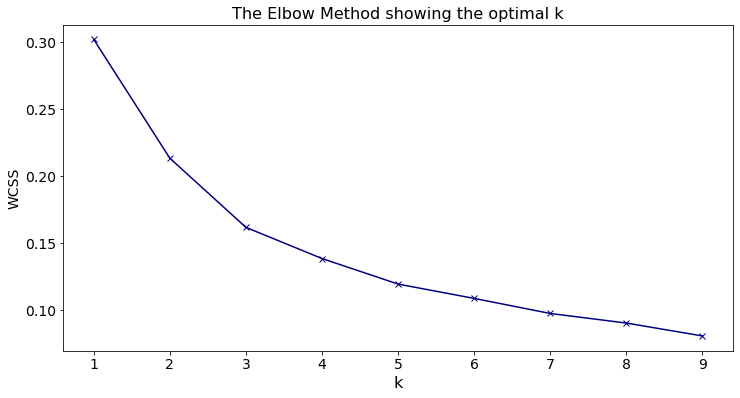

In [20]:
# K-means

from sklearn.cluster import KMeans
WCSS = [] # within cluster sum of squares
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(weighted_relatedness_mat_policy)
    WCSS.append(kmeanModel.inertia_)
    
plt.figure(figsize=(12,6))
plt.plot(K, WCSS, 'bx-', color = 'navy')
plt.xlabel('k',fontsize = 16)
plt.ylabel('WCSS', fontsize = 14)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.title('The Elbow Method showing the optimal k', fontsize = 16)
plt.savefig('github_outputs/elbow_method_plot_clusters.jpg',dpi = 200,bbox_inches = 'tight')


In [21]:
# identify clusters based on k = 3, 5 and 8
kmeans_embedding_3 = KMeans(n_clusters = 3,random_state=0).fit(weighted_relatedness_mat_policy)
kmeans_embedding_5 = KMeans(n_clusters = 5,random_state=0).fit(weighted_relatedness_mat_policy)
kmeans_embedding_8 = KMeans(n_clusters = 8,random_state=0).fit(weighted_relatedness_mat_policy)
#nl['kmeans_embedding_8_clusters_RCA_weighted_prox_mat']=kmeans_embedding.labels_


### Construct node list for Climate Policy Space Network

In [22]:

nl = pd.DataFrame()
nl['Id'] = [x for x in range(len(M_df.columns))]
nl['Label'] = list(M_df.columns)

# Include policy prevalence and adoption history
nl['Climate Policy Prevalence']= M.sum(axis = 0)
nl['Number of times adopted']= N.sum(axis = 0)

# Include clusters
nl['kmeans_3_clusters']=kmeans_embedding_3.labels_
nl['kmeans_5_clusters']=kmeans_embedding_5.labels_
nl['kmeans_8_clusters']=kmeans_embedding_8.labels_

# Mean income level associated with policy
gdp_cap = pd.read_csv('github_raw/WB_GDP_cap_current_USD.csv')
WB_country_data = pd.read_csv('github_raw/WB_country_labels.csv', encoding = 'latin1')

gdp1= pd.merge(M_df,WB_country_data, left_on = M_df.index, right_on ='Economy',how = 'left')
gdp2 = pd.merge(gdp1, gdp_cap[['Country Code','2019']],left_on = 'Code', right_on = 'Country Code',how = 'left')
#drop countries with no gdp data
gdp3 = gdp2.dropna(subset = ['2019'])

policies = M_df.columns
policy_gdp_means = []

for p in policies:
    policy_vector = gdp3[p]
    gdp_vector = gdp3['2019']
    numerator = np.dot(policy_vector,gdp_vector)
    denominator = policy_vector.sum()
    mean_gdp = numerator/float(denominator)
    policy_gdp_means.append(mean_gdp)
    
nl['policy_gdp_mean']=policy_gdp_means

# Representation of policy adoption in key income groups

ig = list(gdp3['Income group'].unique())

for i in ig:
    i_country_data = gdp3[gdp3['Income group']==i]
    policy_ig_proportion = []
    for p in policies:
        policy_vector = i_country_data[p]
        sum_policies = np.sum(policy_vector)
        proportion_policies = sum_policies/float(len(i_country_data[p]))
        policy_ig_proportion.append(proportion_policies)
    nl[i+'_policy_proportion']=policy_ig_proportion
 

In [24]:
# Output node and edge list
df_new_edges.to_csv('github_outputs/gephi_edgelist_CPS_network_weighted_relatedness_policy_all_years_05sd.csv', index = False)
nl.to_csv('github_outputs/gephi_nodelist_CPS_network_weighted_relatedness_policy_all_years_05sd.csv', index = False)